In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set(context='poster', style='white', font='Ubuntu')

all_train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [159]:
breed_list = [u'rottweiler', u'lhasaapso', u'chihuahua', u'weimaraner', u'shihtzu', 
         u'chinesesharpei', u'alaskanmalamute', u'entlebucher', u'vizsla', u'italiangreyhound', u'redbonehound', u'plotthound', 
         u'chowchow', u'irishsetter', u'bassethound', u'bostonterrier', u'englishshepherd', 
         u'stbernard', u'pbgv', u'bloodhound', u'staffordshire', u'englishspringerspaniel', u'pitbull', u'husky', 
         u'snowshoe', u'domesticmediumhair', u'mix', u'mainecoon', u'turkishvan', u'siamese', u'havanabrown', 
         u'domesticlonghair', u'shorthair', u'russianblue', u'cornishrex', u'domesticshorthair', u'exoticshorthair']

def cleanBreed(all_train):
    all_train['Breed'] = all_train['Breed'].str.replace('Black/Tan', 'BlackTan')
    all_train['Breed'] = all_train['Breed'].str.replace('/Unknown', ' Unknown')
    all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Rough Coat', 'StBernard')
    all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Smooth Coat', 'StBernard')
    all_train['Breed'] = all_train['Breed'].str.replace('German Shorthair Pointer', 'Pointer')
    all_train['Breed'] = all_train['Breed'].str.replace('German Wirehaired Pointer', 'Pointer')
    all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Longhair', 'Dachshund')
    all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Wirehair', 'Dachshund')
    all_train['Breed'] = all_train['Breed'].str.replace('English Pointer', 'Pointer')
    all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Shorthair', 'Chihuahua')
    all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Longhair', 'Chihuahua')
    all_train['Breed'] = all_train['Breed'].str.replace('Alaskan Husky', 'Husky')
    all_train['Breed'] = all_train['Breed'].str.replace('Siberian Husky', 'Husky')
    
    all_train['Breed'] = all_train['Breed'].str.replace(' ', '')
    all_train['Breed'] = all_train['Breed'].str.replace('/', ' Mix ')
    all_train['Breed'] = all_train['Breed'].str.replace('Unknown', '')
    all_train['Breed'] = all_train['Breed'].str.replace('Australian', '')
    all_train['Breed'] = all_train['Breed'].str.replace('American', '')
    all_train['Breed'] = all_train['Breed'].str.replace('German', '')
    all_train['Breed'] = all_train['Breed'].str.replace('YorkshireTerrier', ' Yorkshire ')
    all_train['Breed'] = [x.lower() for x in all_train['Breed']]

    for a in range(len(breed_list)):
        all_train[breed_list[a]] = [np.array([breed_list[a] in x]).astype(int) for x in all_train['Breed']] 
    
    return(all_train)

all_train = cleanBreed(all_train)
test = cleanBreed(test)


In [291]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dayOfWeek_alt={0:'Monday', 1:'TuesFri', 2:'TuesFri', 3:'TuesFri', 4:'TuesFri', 5:'SatSun', 6:'SatSun'}
MonthName={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep',10:'Oct',11:'Nov',12:'Dec'} 
MonthName_alt={1:'JanFeb', 2:'JanFeb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
               8:'Aug', 9:'SepNov',10:'SepNov',11:'SepNov',12:'Dec'}
timeOfDay = {5: 'Morning', 6: 'Morning', 7: 'Morning', 8: 'Morning', 9: 'Morning', 10: 'Morning', 11: 'Afternoon',
        12: 'Afternoon', 13: 'Afternoon', 14: 'Afternoon', 15: 'Afternoon', 16: 'Night', 17: 'Night', 18: 'Night',
        19: 'Night', 20: 'Night', 21: 'Night', 22: 'Night', 23: 'Night', 0: 'Midnight',}

def shortenBreed(s):
    s = s.lower()
    s = re.sub(' mix', '', s)
    s = re.sub('\\/.*', '', s)
    return s


def RecodeAges(s):
    more3_yr = ['13year','14year','15year','16year','17year','18year','19year','20year','3year','4year','5year','6year','7year','8year','9year','10year','11year','12year']
    lessone_yr = ['3month','4month','5month','6month','7month','8month','9month','10month','11month','0year']
    lessone_wk = ['1day','2day','3day','4day','5day','6day']
    lessone_mo = ['1week','1week','2week','3week','4week']
    oneortwo_mo = ['1month','5week','2month']
    oneortwo_yr = ['1year','2year']
    
    if isinstance(s, str):
        age = re.sub('[s, ]','', s)
    else:
        return 'UnknownAge'
    
    if age in more3_yr:
        return age
    elif age in lessone_yr:
        return '< 1yr'
    elif age in lessone_mo:
        return '< 1mo'
    elif age in oneortwo_mo:
        return '1 - 2 mos'
    elif age in oneortwo_yr:
        return '1 - 2 yrs'
    else:
        return '< 1wk'

def mixedBreed(s):
    if 'mix' in s.lower():
        return 1
    else:
        return 0

significant_dates = list(test.groupby(test.DateTime.dt.normalize()).count()['DateTime']\
                     .sort_values(ascending=False)[:10].index)

date_cols = [str(x)[:10] for x in significant_dates]

def process_data(df):
    df.ix[pd.isnull(df['Name']), 'Named'] = 'Unnamed'
    df.ix[pd.isnull(df['Named']), 'Named'] = 'Named'
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['weekday'] = df['DateTime'].dt.dayofweek.map(dayOfWeek_alt)
    df['month'] = df['DateTime'].dt.month.map(MonthName_alt)
    df['hour'] = df['DateTime'].dt.hour
    df['minute'] = df['DateTime'].dt.minute
    df['minutezero'] = (df['minute'] == 0).astype(int)
    df['ageGroups'] = df['AgeuponOutcome'].map(RecodeAges)
    df['mix'] = df['Breed'].map(mixedBreed)
    df['shortBreed'] = df['Breed'].map(shortenBreed)

    for dt in significant_dates:
        df[str(dt)[:10]] = map(lambda x: x.normalize() == dt, df.DateTime)
        df[str(dt)[:10]] = df[str(dt)[:10]].astype(int)
    
    df['corp'] = df.apply(lambda x: ' '.join((x.Color, x.SexuponOutcome, x.Named, 
                                                       x.weekday, x.month)), axis=1)

    return df

all_train = process_data(all_train)



cv = CountVectorizer(min_df=0.05)
train_corpus = cv.fit_transform(all_train.corp)

def add_other_features(corpus, df, training=True):
    dense_corpus = pd.DataFrame(corpus.toarray(), columns = cv.get_feature_names())

    add = pd.concat([(df.AnimalType == 'Dog').astype(int), 
                     df.minutezero,
                     df[date_cols],
                     pd.get_dummies(df.hour),
                    pd.get_dummies(df.ageGroups),
                    df.ix[:,breed_list]], axis=1)
    
    if training:
        add = pd.concat([add, df.OutcomeType], axis=1)
    return pd.concat([dense_corpus, add], axis=1)

new_corp = add_other_features(train_corpus, all_train)

split = new_corp.shape[0] // 20
dev = new_corp.iloc[:split,:-1]
train = new_corp.iloc[split:,:-1]

dev_labels = new_corp.iloc[:split,-1]
train_labels = new_corp.iloc[split:,-1]

test = process_data(test)


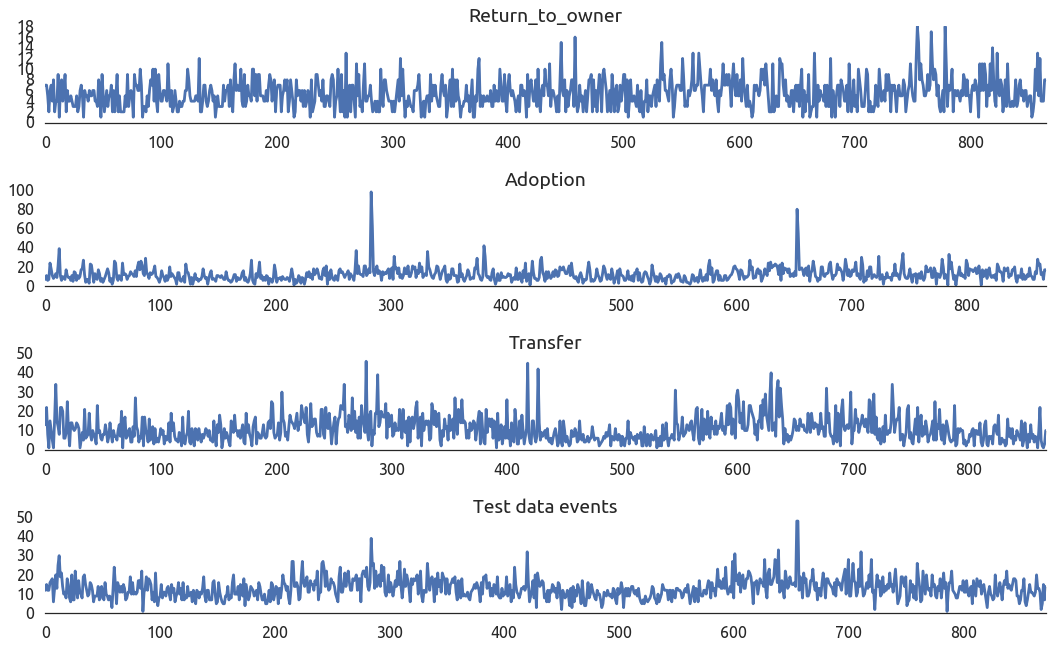

In [111]:
plt.figure(figsize=(15,9))
for i, outcome in enumerate(['Return_to_owner','Adoption','Transfer']):
    d = all_train[all_train.OutcomeType == outcome]
    plt.subplot(4,1,i+1)
    sns.tsplot(d.groupby([d.DateTime.dt.normalize()]).count()['AnimalID'])
    plt.title(outcome)
    plt.tight_layout()
    sns.despine(left=True)
    
plt.subplot(4,1,4)
sns.tsplot(test.groupby([test.DateTime.dt.normalize()]).count()['DateTime'])
plt.title('Test data events')
sns.despine(left=True)


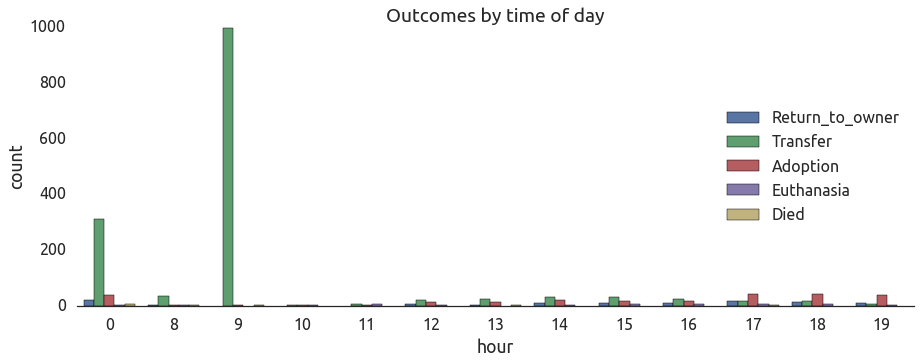

In [6]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by time of day')

sns.countplot(x='hour', hue='OutcomeType', data=all_train[all_train['minutezero'] == 1])
plt.legend(loc='right')

sns.despine(left=True)

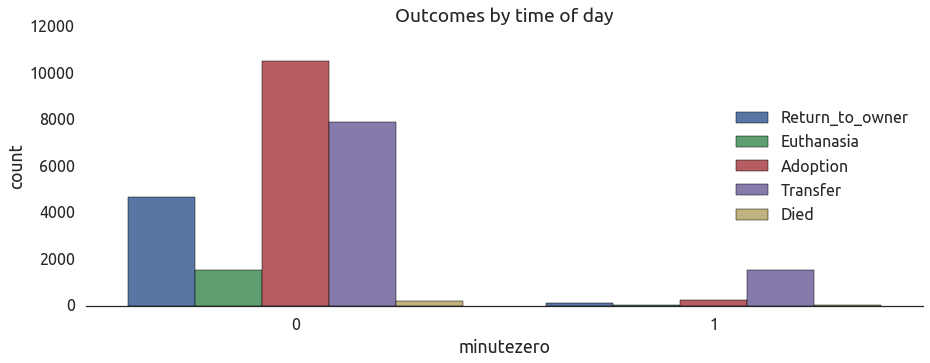

In [7]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by time of day')

sns.countplot(x='minutezero', hue='OutcomeType', data=all_train)
plt.legend(loc='right')


sns.despine(left=True)

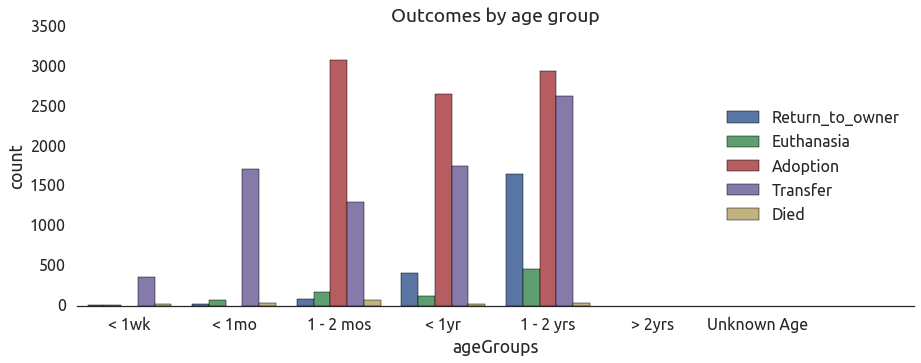

In [8]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by age group')

sns.countplot(x='ageGroups', hue='OutcomeType', data=all_train, 
              order=['< 1wk','< 1mo','1 - 2 mos', '< 1yr','1 - 2 yrs','> 2yrs','Unknown Age',' '])
plt.legend(loc='right')

sns.despine(left=True)

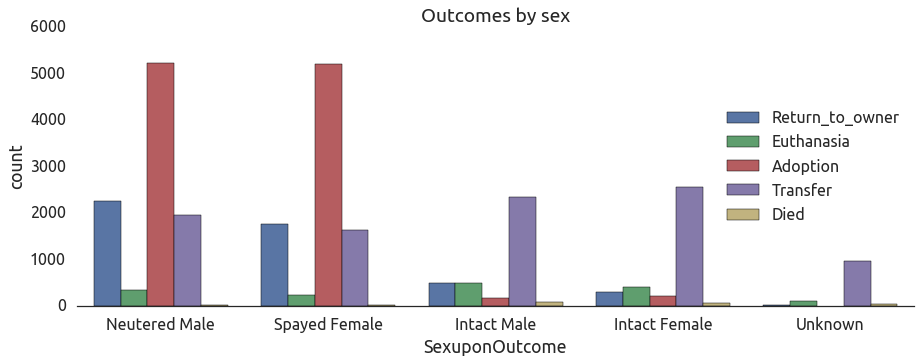

In [9]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by sex')

sns.countplot(x='SexuponOutcome', hue='OutcomeType', data=all_train)
plt.legend(loc='right')

sns.despine(left=True)

Breed feature unique count: 1291


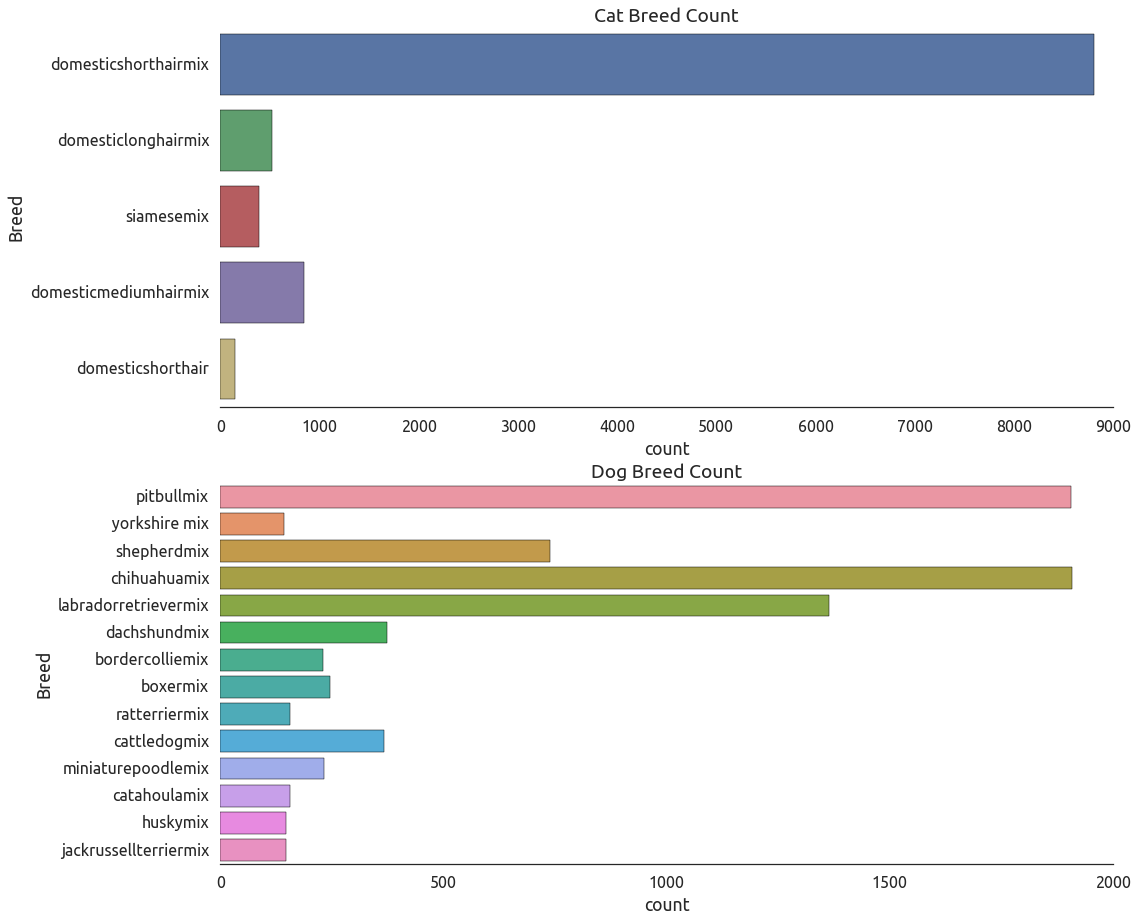

In [23]:
##Exploring some of the breed features

print 'Breed feature unique count:', len(all_train.groupby(['Breed'])['Breed'].nunique())

all_train_cat = all_train[all_train['AnimalType']=='Cat']
all_train_dog = all_train[all_train['AnimalType']=='Dog']

pop_cat = list(all_train_cat['Breed'].value_counts()[all_train_cat['Breed'].value_counts() > 100].index)
plot_cat = all_train_cat[all_train_cat['Breed'].isin(pop_cat)]

pop_dog = list(all_train_dog['Breed'].value_counts()[all_train_dog['Breed'].value_counts() > 140].index)
plot_dog = all_train_dog[all_train_dog['Breed'].isin(pop_dog)]

plt.figure(figsize=(16,15))

plt.subplot(2,1,1)
sns.countplot(y='Breed', data=plot_cat)
sns.plt.title('Cat Breed Count')

plt.subplot(2,1,2)
sns.countplot(y='Breed', data=plot_dog)
plt.title('Dog Breed Count')

sns.despine(left=True)

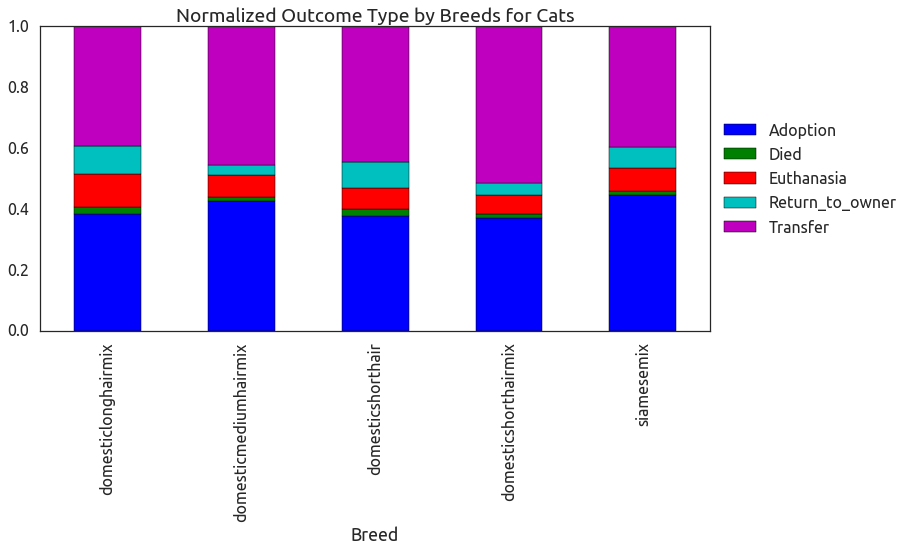

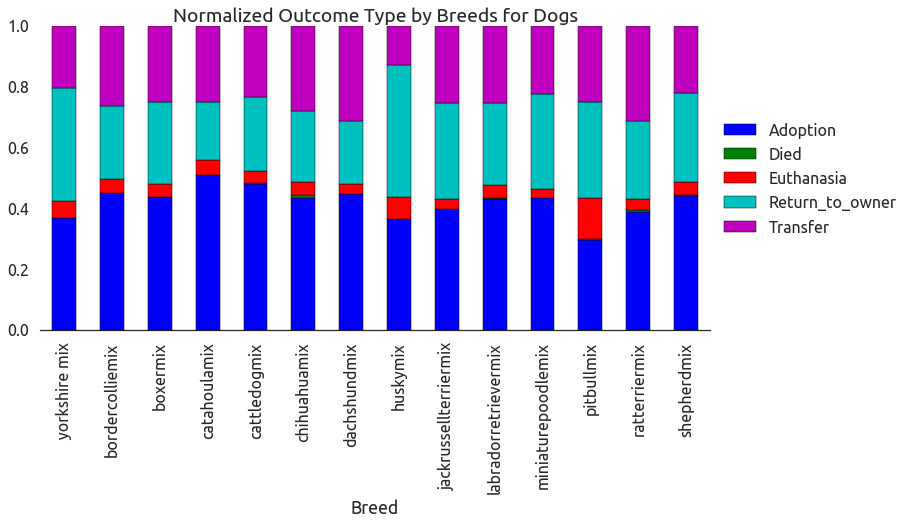

In [24]:
##Taking the popular animals and seeing how their outcomes vary
cat_outcome = plot_cat.groupby(['Breed','OutcomeType']).size().unstack()
cat_outcome_normalized = cat_outcome.div(plot_cat.groupby(['Breed']).size(),axis='rows')
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,1,1)
ax = cat_outcome_normalized.plot(kind='bar',stacked=True,ax=ax, title="Normalized Outcome Type by Breeds for Cats")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


dog_outcome = plot_dog.groupby(['Breed','OutcomeType']).size().unstack()
dog_outcome_normalized = dog_outcome.div(plot_dog.groupby(['Breed']).size(),axis='rows')
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,1,2)
ax = dog_outcome_normalized.plot(kind='bar',stacked=True,ax=ax, title="Normalized Outcome Type by Breeds for Dogs")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine(left=True)


Logistic Regression Log Loss: 0.812
Logistic Regression Accuracy: 0.663


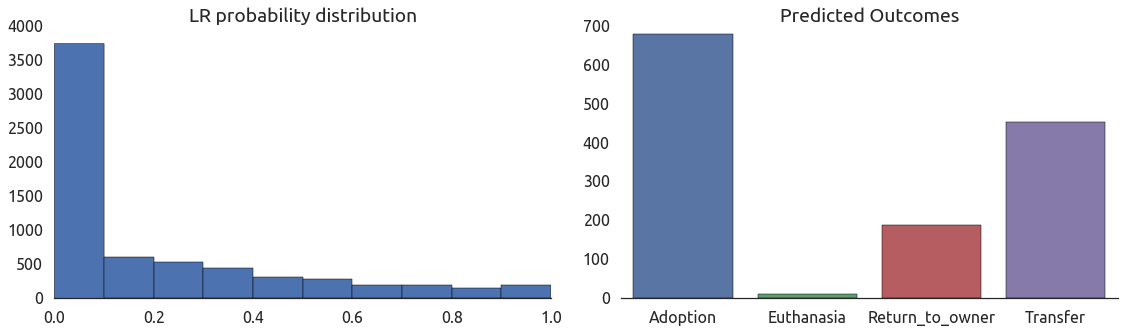

In [293]:
clf = LogisticRegression(penalty='l1', C=1)
clf.fit(train, train_labels)
probs = clf.predict_proba(dev)
preds = clf.predict(dev)
print 'Logistic Regression Log Loss: {:.3f}'.format(log_loss(dev_labels, probs))
print 'Logistic Regression Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))


plt.figure(figsize=(16,5)) 
# plt.subplot(1,2,1)
# sns.barplot(, orient="h", palette='Blues_d')
# plt.title('Feature Weights')

plt.subplot(1,2,1)
plt.hist(probs.ravel(), range=[0,1])
plt.title('LR probability distribution')

plt.subplot(1,2,2)
sns.barplot(np.unique(preds, return_counts=True)[0], np.unique(preds, return_counts=True)[1])
plt.title('Predicted Outcomes')


# clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, criterion='entropy')
# clf.fit(train, train_labels)
# preds = clf.predict_proba(dev)
# print 'RF Log Loss: {:.3f}'.format(log_loss(dev_labels, preds, eps=0.1))
# print 'RF Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

# plt.subplot(2,2,4)
# plt.hist(preds.ravel(), range=[0,1])
# plt.title('RF probability distribution')

plt.tight_layout()
sns.despine(left=True)

[[455   0   0  42  44]
 [  0   0   0   0   5]
 [ 25   0   3  12  40]
 [127   0   0  88  33]
 [ 93   0   1  42 326]]


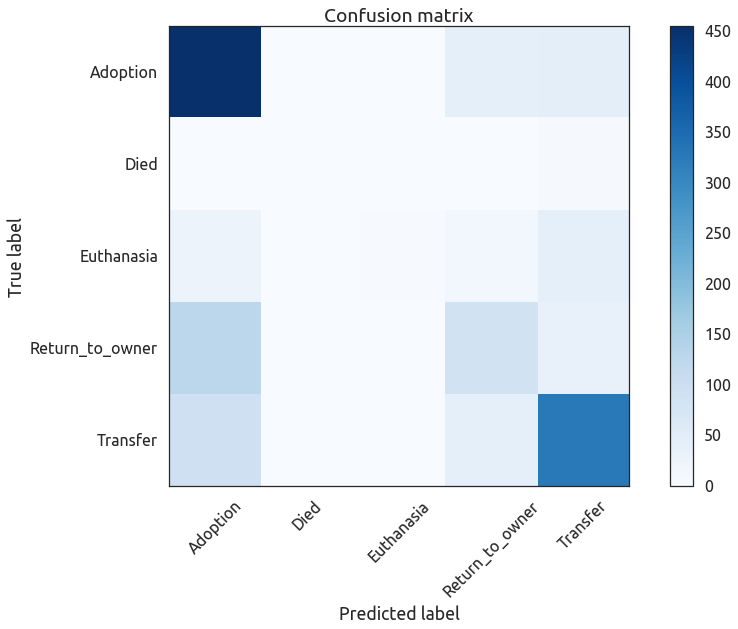

In [165]:
# print clf.classes_
cm = confusion_matrix(dev_labels, preds, labels=clf.classes_)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=clf.classes_):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm


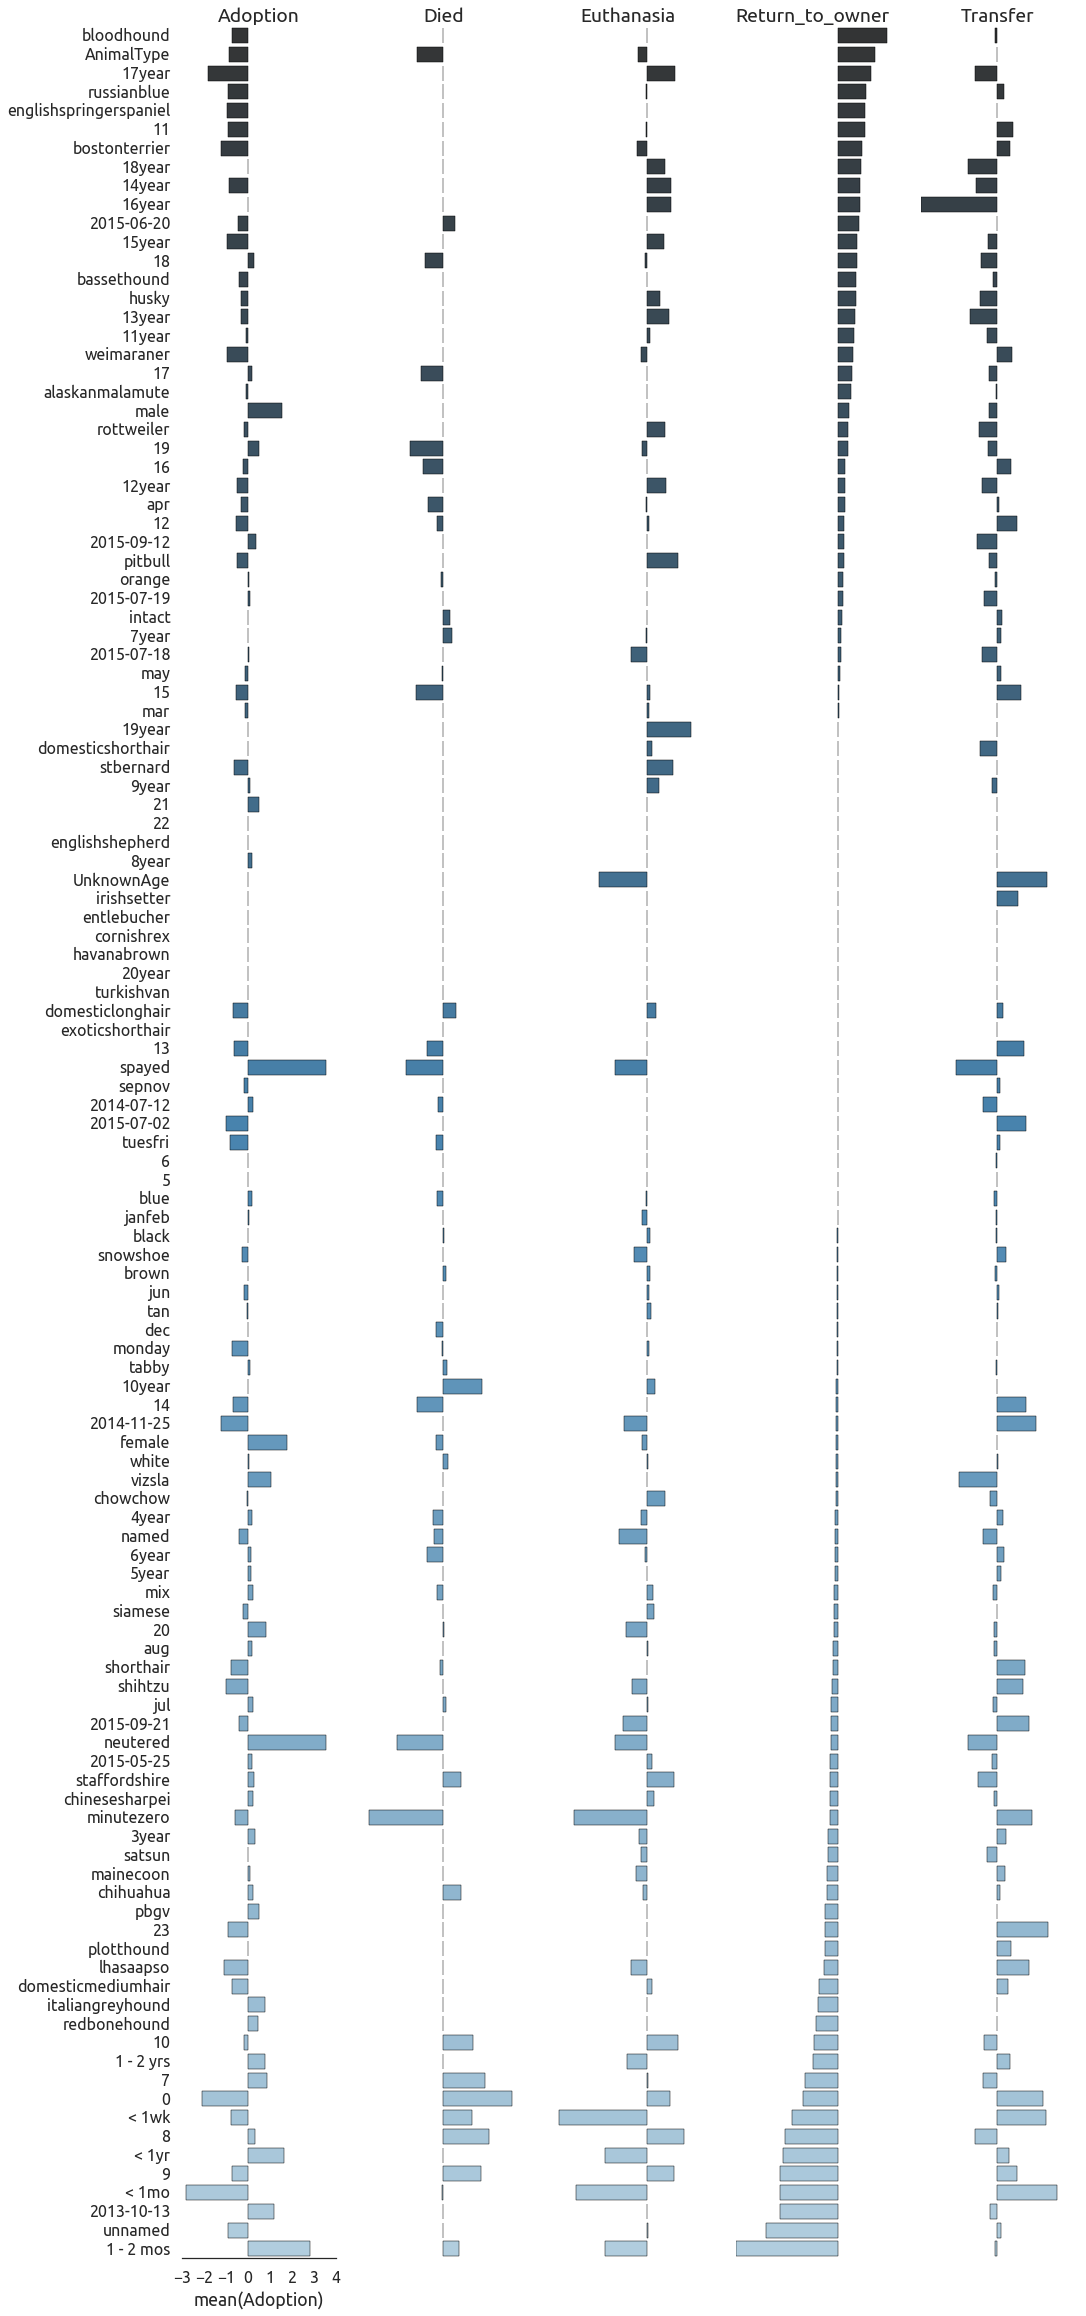

In [292]:
feat_import = pd.DataFrame(clf.coef_, 
                           columns=train.columns, 
                           index=clf.classes_).T.sort_values('Return_to_owner', ascending=False)


plt.figure(figsize=(16,40)) 

for i, j in enumerate(feat_import.columns):
    plt.subplot(1,5,i + 1)
    sns.barplot(x=feat_import.loc[:,j], y=feat_import.index, orient="h", palette='Blues_d')
    plt.title(j)
    if i > 0:
        plt.axis('off')
        
sns.despine(left=True)

In [289]:
for sensitivity in [0, 0.001, 0.01, 0.1, 0.5, 1]:
    reduced_train = train.iloc[:,np.where(abs(np.sum(clf.coef_, axis=0)) > sensitivity)[0]]
    reduced_dev = dev.iloc[:,np.where(abs(np.sum(clf.coef_, axis=0)) > sensitivity)[0]]

    clf_new = LogisticRegression(penalty='l2', C=1)
    clf_new.fit(reduced_train, train_labels)
    probs = clf_new.predict_proba(reduced_dev)
    preds = clf_new.predict(reduced_dev)
    print 'LR loss with sensitivity {:.2f}: {:.3f} with {:d} columns'.format(sensitivity, log_loss(dev_labels, probs),
                                                                            len(reduced_train.columns))


LR loss with sensitivity 0.00: 0.812 with 110 columns
LR loss with sensitivity 0.00: 0.812 with 109 columns
LR loss with sensitivity 0.01: 0.812 with 109 columns
LR loss with sensitivity 0.10: 0.812 with 96 columns
LR loss with sensitivity 0.50: 0.822 with 50 columns
LR loss with sensitivity 1.00: 0.857 with 27 columns


In [294]:
clf.fit(new_corp.iloc[:,:-1], new_corp.iloc[:,-1])

test = process_data(test)

test_corpus = cv.transform(test.corp)
new_test = add_other_features(test_corpus, test, training=False)

preds = clf.predict_proba(new_test)

for i, outcome in enumerate(clf.classes_):
    test[outcome] = preds[:,i]
    
test['prediction'] = clf.predict(new_test)

submission = test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]
submission.to_csv('submission.csv', index=False)

In [295]:
dogs = new_corp[new_corp.AnimalType == 1]
cats = new_corp[new_corp.AnimalType == 0]
dogs_test = new_test[new_test.AnimalType == 1]
cats_test = new_test[new_test.AnimalType == 0]

clf.fit(dogs.iloc[:,:-1], dogs.iloc[:,-1])
preds = clf.predict_proba(dogs_test)
dogs_test['ID'] = test[test.AnimalType == 'Dog']['ID']
for i, outcome in enumerate(clf.classes_):
    dogs_test[outcome] = preds[:,i]
    
clf.fit(cats.iloc[:,:-1], cats.iloc[:,-1])
preds = clf.predict_proba(cats_test)
cats_test['ID'] = test[test.AnimalType == 'Cat']['ID']
for i, outcome in enumerate(clf.classes_):
    cats_test[outcome] = preds[:,i]
    
submission = pd.concat([dogs_test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']],
                       cats_test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]])
submission.to_csv('submission.csv', index=False)

/Users/Darren/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Darren/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Darren/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s